# LRD project

# Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
from astropy import visualization
from matplotlib import pyplot as plt

# LRD information

In [2]:
targets = {
    4286  : (3.619202, -30.423270),
    13123 : (3.579829, -30.401570),
    13821 : (3.620607, -30.399951),
    20466 : (3.640409, -30.386437),
    23608 : (3.542815, -30.380646),
    35488 : (3.578984, -30.362598),
    38108 : (3.530009, -30.358013),
    41225 : (3.533994, -30.353308),
}

# confirmed broadlines in UNCOVER except 45924, because really bright and breaks these simple tests

In [3]:
# [z, mu, L_Ha, L_bol, F277 – F356]
supplemental = {
    4286  : ( 5.84, 1.62,  43.4, 45.4, 1.19),
    13123 : ( 7.04, 6.15,  42.7, 45.0, 1.89),
    13821 : ( 6.34, 1.59,  43.3, 45.4, 1.40),
    20466 : ( 8.50, 1.33,  43.8, 45.8, 0.72),
    23608 : ( 5.80, 2.07,  42.3, 44.2, 0.88),
    35488 : ( 6.26, 3.38,  42.8, 44.8, 0.99),
    38108 : ( 4.96, 1.59,  43.4, 45.3, 0.83),
    41225 : ( 6.76, 1.50,  43.5, 45.3, 0.71),
}

In [4]:
bands = ['f480m',
         'f460m',
         'f444w',
         'f430m',
         'f410m',
         'f360m',
         'f356w',
         'f335m',
         'f300m',
         'f277w',
         'f250m',
         'f210m_block40',
         'f200w_block40',
         'f182m_block40',
         'f162m_block40',
         'f150w_block40',
         'f140m_block40',
         'f115w_block40',
         'f090w_block40',
         'f070w_block40']

# Functions

In [5]:
def residual(theta, x, y, z, z_err, sumit = False):
    sigma, scale, bkg, xmu, ymu = theta
    
    model = gauss2d(x,y,sigma=sigma,scale=scale,bkg=bkg,xmu=xmu,ymu=ymu)
    
    chi = np.power(model - z,2)/z_err**2
    
    if sumit:
        return np.nansum(chi)
    else:
        c = chi.ravel()
        return c[np.isfinite(c)]
    
def gauss2d(x,y,sigma,scale,bkg,xmu=0,ymu=0,unravel=False):
    """
    Symmetric 2D point-spread function (PSF)
    
    inputs:
        x: np.ndarray, where to evaluate the PSF
        y: np.ndarray, where to evaluate the PSF
        sigma: float, width of the PDF
        scale: float, integrated area under the PSF
        bkg: float, background flux level
        xmu: float, center of PSF in x
        ymu: float, center of PSF in y
    outputs:
        PSF evalauted at x and y
    """
    exponent = (np.power(x-xmu,2) + np.power(y-ymu,2) ) / sigma**2
    
    mod = scale * np.exp(-exponent) / (2*np.pi*sigma**2) + bkg
    if unravel:
        return mod.ravel()
    else:
        return mod
    
def fit_with_func(image, error, first_guess):
    
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    X,Y = np.meshgrid(x,y)

    out = scipy.optimize.leastsq(residual, 
                              x0 = first_guess,
                              args = (X,Y,image,error),
                              full_output = True
                                )
    return out[0], X, Y

def radial_profile(image, error, step = 5, steps = 4):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    X,Y = np.meshgrid(x,y)

    x0 = image.shape[0]/2
    y0 = image.shape[0]/2  
    
    R  = np.sqrt( np.power(X-x0,2) + np.power(Y-y0,2) ) 
    
    radii,fluxes,errors,areas = [],[],[],[]
    r0 = 0
    for i in range(steps):
        C = (R<r0+step) & (R>=r0)

        radii.append(r0+step/2)
        fluxes.append( np.nansum(image[C]) ) 
        errors.append( np.sqrt( np.nansum(np.power(error[C],2) )) )
        areas.append( len(C[C]) )
        
        r0 += step
        
    return np.array(radii), np.array(fluxes), np.array(errors), np.array(areas)

def get_circle(r, x0,y0):
    theta = np.linspace(0, 2 * np.pi, 100)
    
    return x0 + r * np.sin(theta), y0 + r * np.cos(theta)

def find_half_light_radius(x,y,n=100):
    xp = np.linspace(x.min(), x.max(), n)
    yp = np.interp(xp,x,y)
    
    ap = [0]
    for i in range(1,n):
        ap.append( np.trapz(yp[:i], xp[:i]) )  
        
    ap  = np.array(ap)
    ap /= ap[-1]
    
    half = np.interp(0.5, ap, xp)
    
    return xp, yp, ap, half

# Compare F444W with the PSF

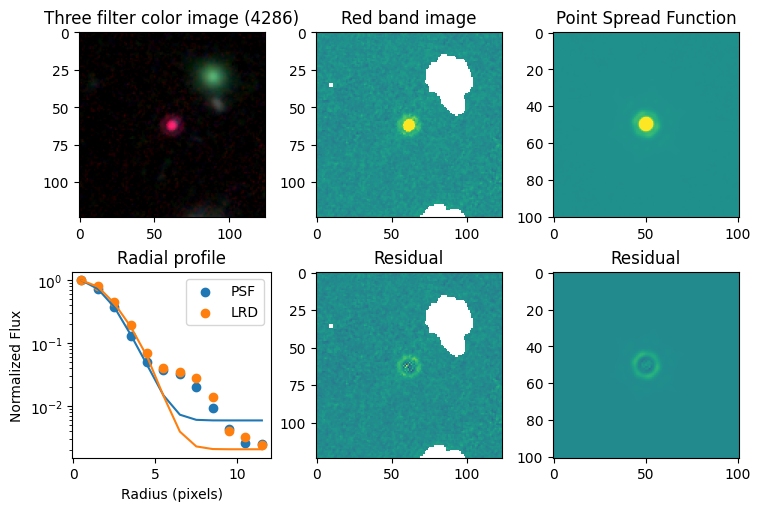

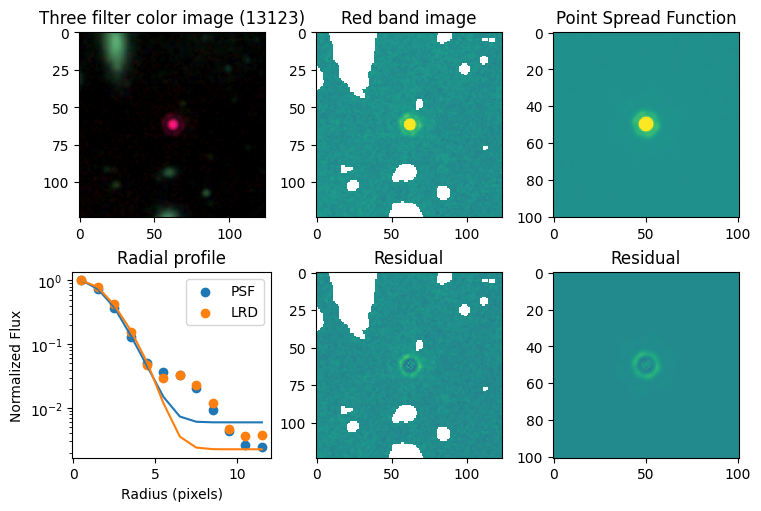

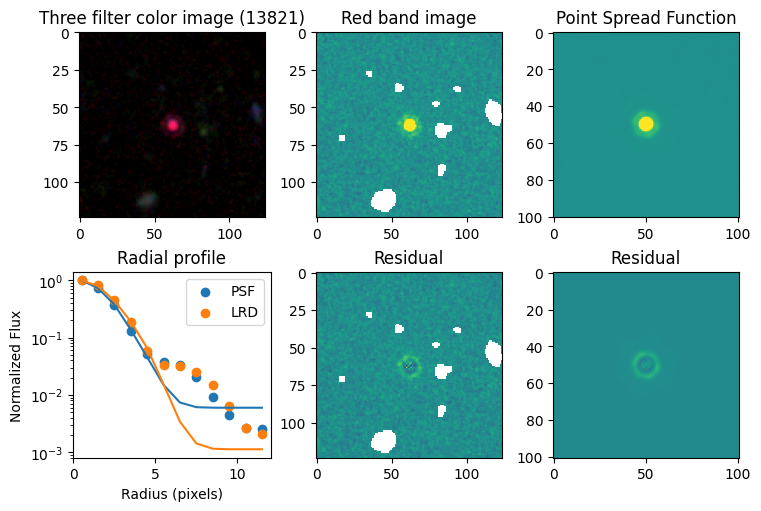

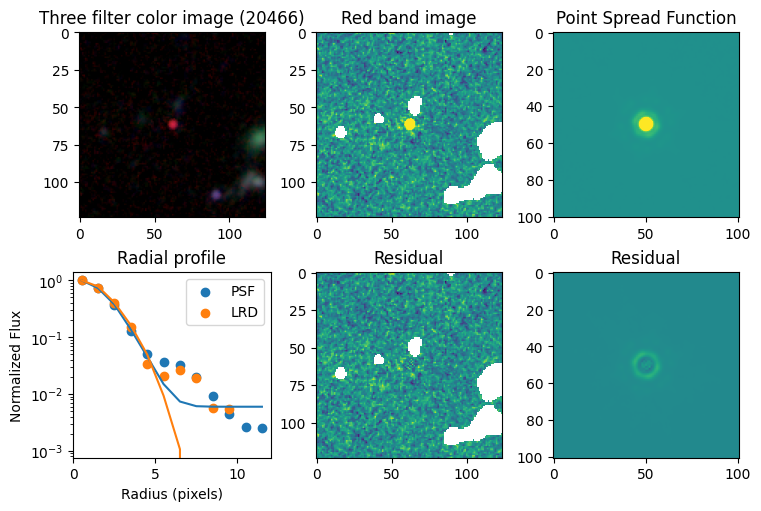

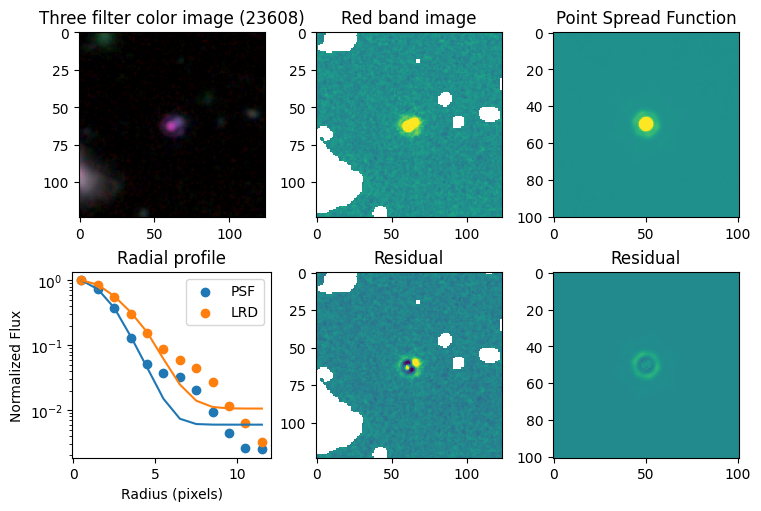

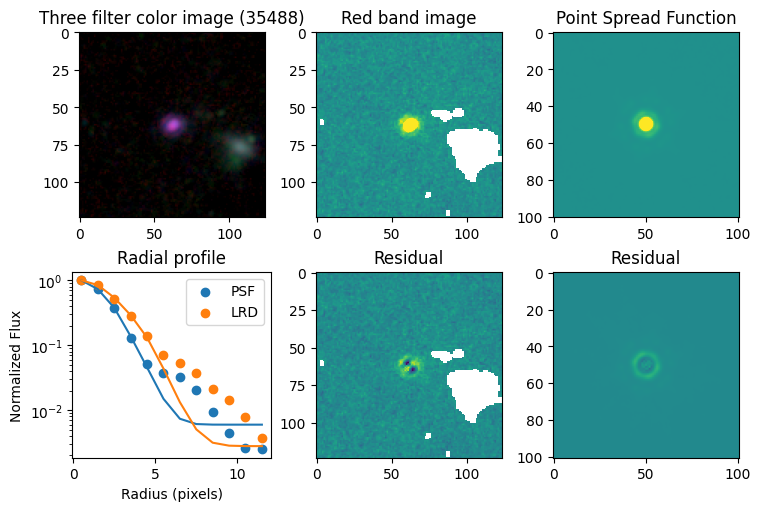

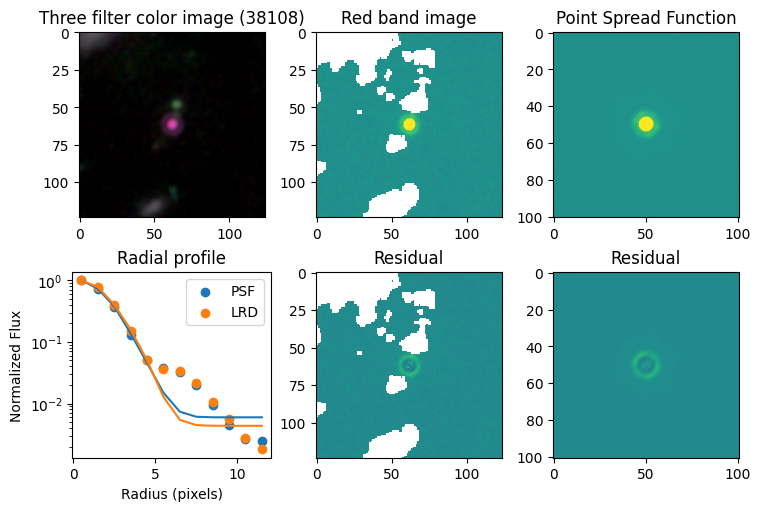

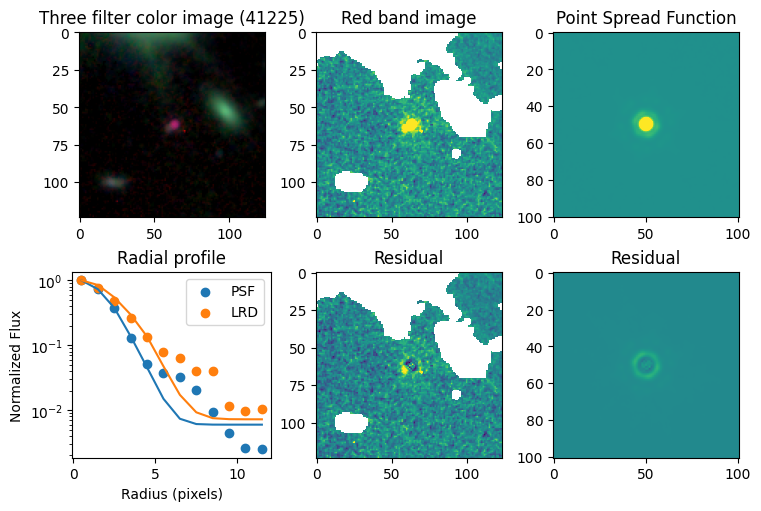

In [6]:
for target in targets.keys():
    
    # load images
    images = np.load(f'data/{target}/sci.npy')
    errors = np.load(f'data/{target}/err.npy')
    masks  = np.load(f'data/{target}/msk.npy')
    psfs   = np.load('data/psf.npy')

    # place we will put the plots
    fig = plt.figure(constrained_layout=True, figsize = (15/2,10/2))
    ax_dict = fig.subplot_mosaic(
        """
        ABC
        DEF
        """)
    
    # show color image
    rgb = visualization.make_lupton_rgb(images[2], images[-11], images[-14],
                                    stretch=0.2)
    
    ax_dict['A'].imshow(rgb)
    ax_dict['A'].set_title(f'Three filter color image ({target})')
    
    # mask out nearby sources
    images[masks] = np.nan
    errors[masks] = np.nan    
    
    # show reddest image
    ax_dict['B'].imshow(images[2], vmin = -np.nanmax(images[2]) / 10, vmax= np.nanmax(images[2]) / 10)    
    ax_dict['B'].set_title('Red band image')

    # show point spread function
    ax_dict['C'].imshow(psfs[-1],  vmin = -np.nanmax(psfs[-1])/10, vmax= np.nanmax(psfs[-1])/10)    
    ax_dict['C'].set_title('Point Spread Function')

    # first science image with a 2D gaussian
    sci = images[2]
    err = errors[2]
    first_guess = [ 5, 
                    700,  
                    0, #np.nanmedian(sci[:10]),  
                    sci.shape[0]/2,  
                    sci.shape[0]/2]

    out_sci, X_sci, Y_sci = fit_with_func(sci, err, first_guess)

    # show residuals 
    ax_dict['E'].imshow(sci - gauss2d(X_sci, Y_sci,*out_sci),  
                        vmin= -np.nanmax(sci) / 10, vmax= np.nanmax(sci) / 10)
    ax_dict['E'].set_title('Residual')
    
    # first fit the PSF with a 2D gaussian
    psf = psfs[-1]
    first_guess = [ 5, 
                    1,  
                    0,  
                    psf.shape[0]/2,  
                    psf.shape[0]/2]

    out_psf, X_psf, Y_psf = fit_with_func(psf, np.ones_like(psf), first_guess)
    
    # show residuals 
    ax_dict['F'].imshow(psf - gauss2d(X_psf, Y_psf,*out_psf),  
                        vmin= -np.nanmax(psf)/10, vmax= np.nanmax(psf)/10)    
    ax_dict['F'].set_title('Residual')
    
    # now calculate 1D radial profiles
    step  = 1
    steps = 12
    r_sci,f_sci,e_sci,a_sci = radial_profile(sci, err, step = step, steps = steps)
    r_sci_m,f_sci_m,e_sci_m,a_sci_m = radial_profile(gauss2d(X_sci, Y_sci,*out_sci), err, step = step, steps = steps)
    
    r_psf,f_psf,e_psf,a_psf = radial_profile(psf, np.ones_like(psf), step = step, steps = steps)
    r_psf_m,f_psf_m,e_psf_m,a_psf_m = radial_profile(gauss2d(X_psf, Y_psf,*out_psf), np.ones_like(psf), step = step, steps = steps)
    
    f_psf /= a_psf
    f_psf_m /= a_psf_m
    
    f_sci /= a_sci
    f_sci_m /= a_sci_m
    
    # plot
    ax_dict['D'].scatter(r_psf, f_psf/f_psf[0], label='PSF')
    ax_dict['D'].scatter(r_sci, f_sci/f_sci[0], label='LRD')
    
    ax_dict['D'].plot(r_psf, f_psf_m/f_psf_m[0])
    ax_dict['D'].plot(r_sci, f_sci_m/f_sci_m[0])
    
    ax_dict['D'].set_yscale('log')
    ax_dict['D'].legend()
    ax_dict['D'].set_title('Radial profile')
    ax_dict['D'].set_ylabel('Normalized Flux')
    ax_dict['D'].set_xlabel('Radius (pixels)')

# Create radial profiles for all bands now

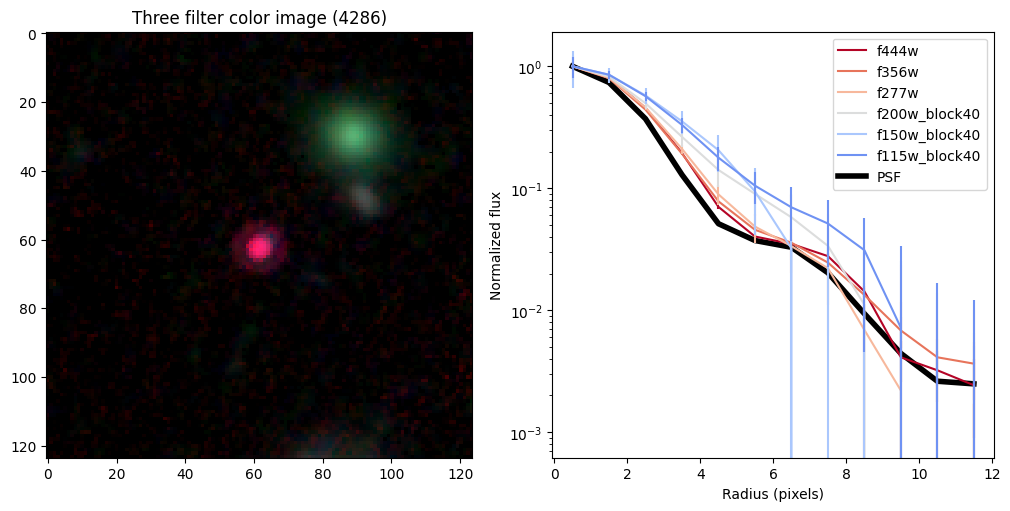

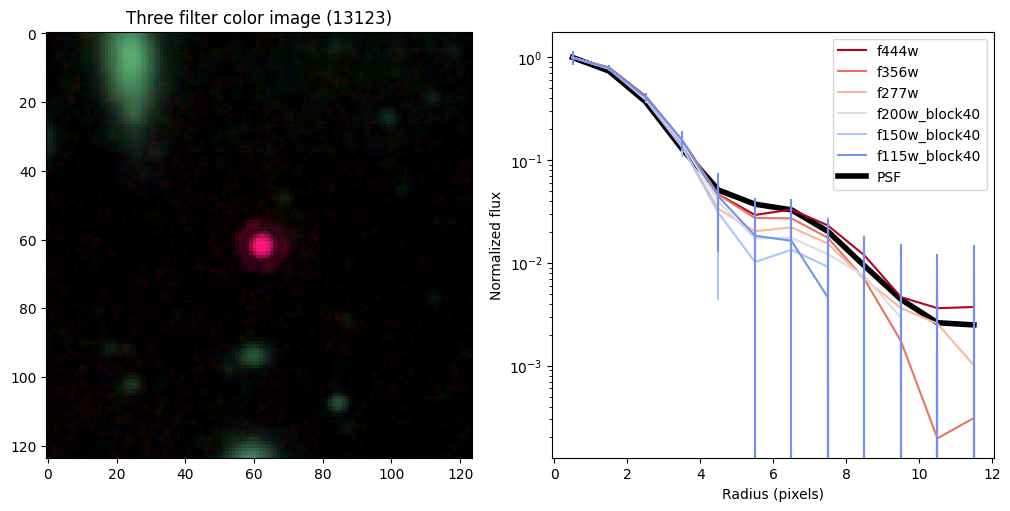

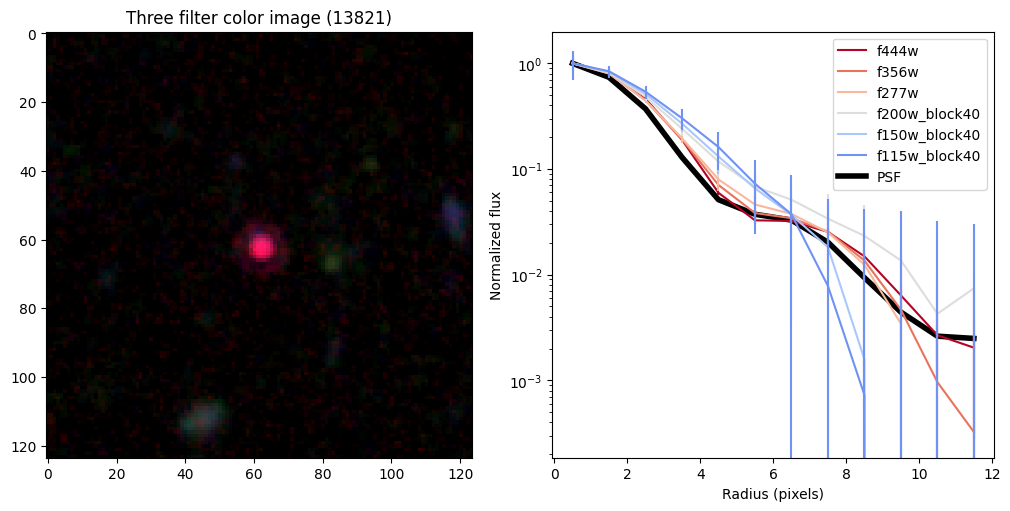

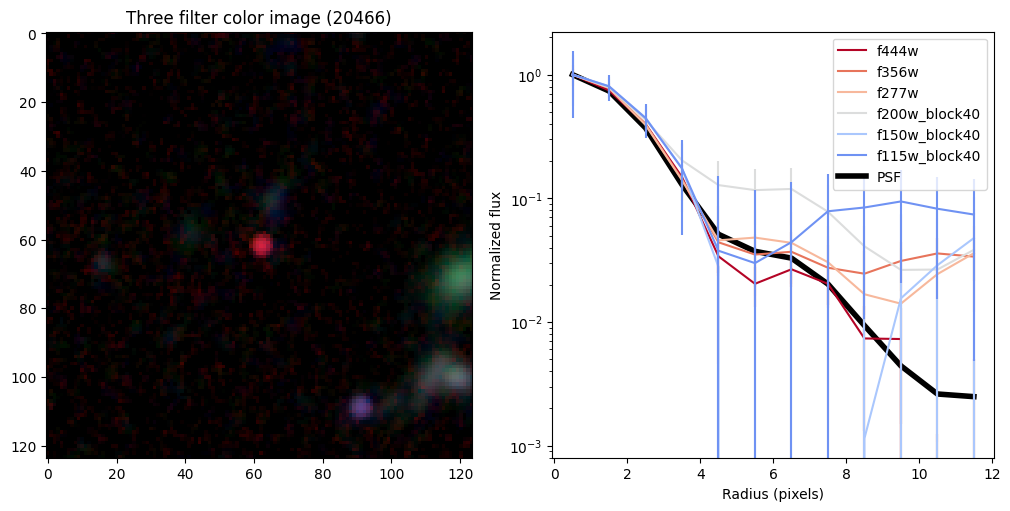

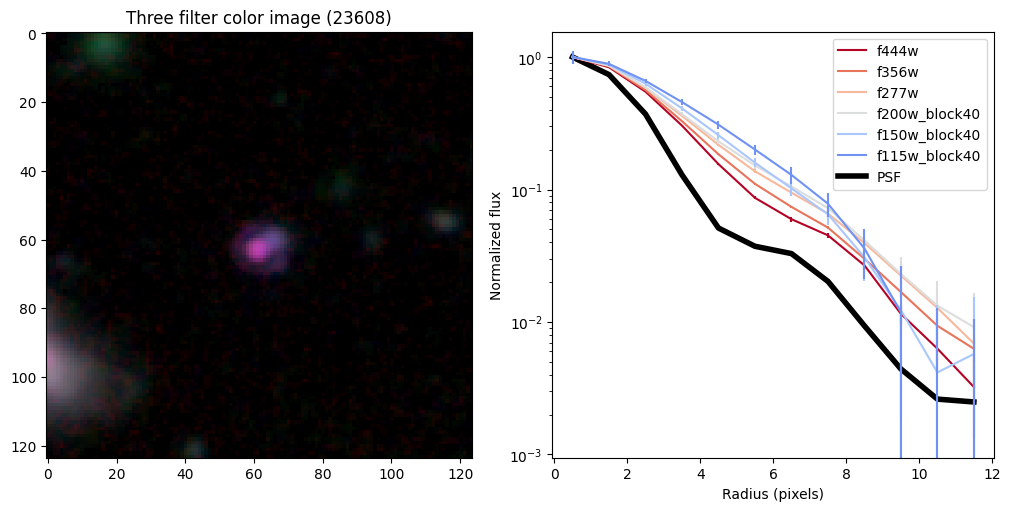

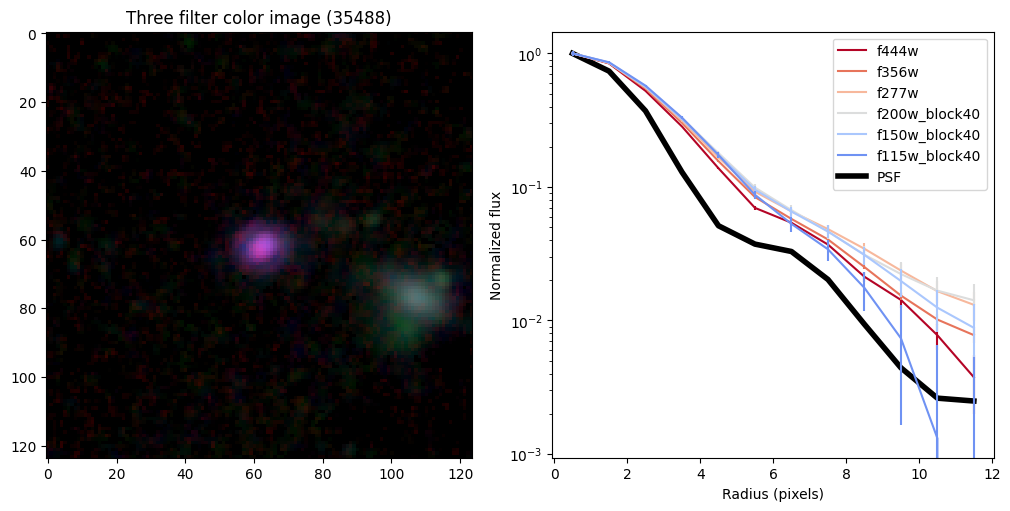

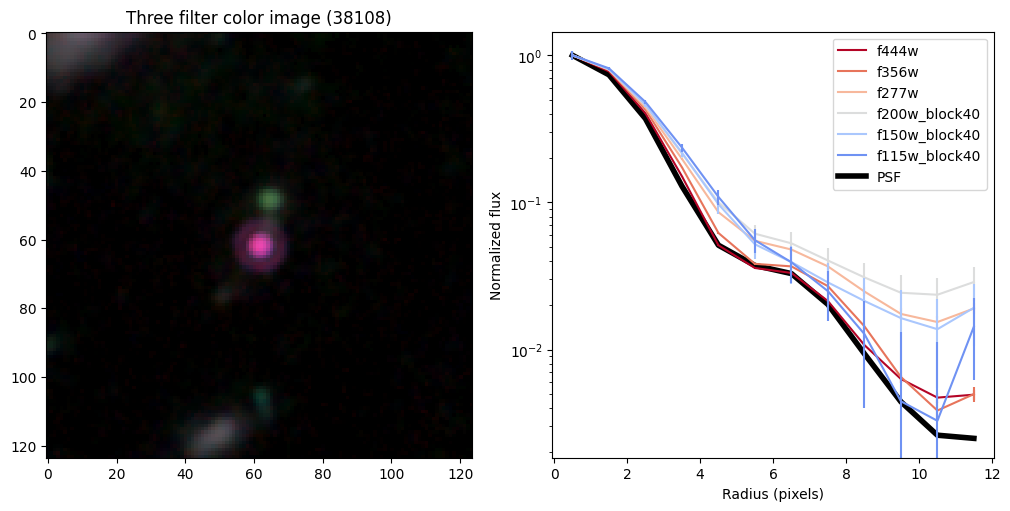

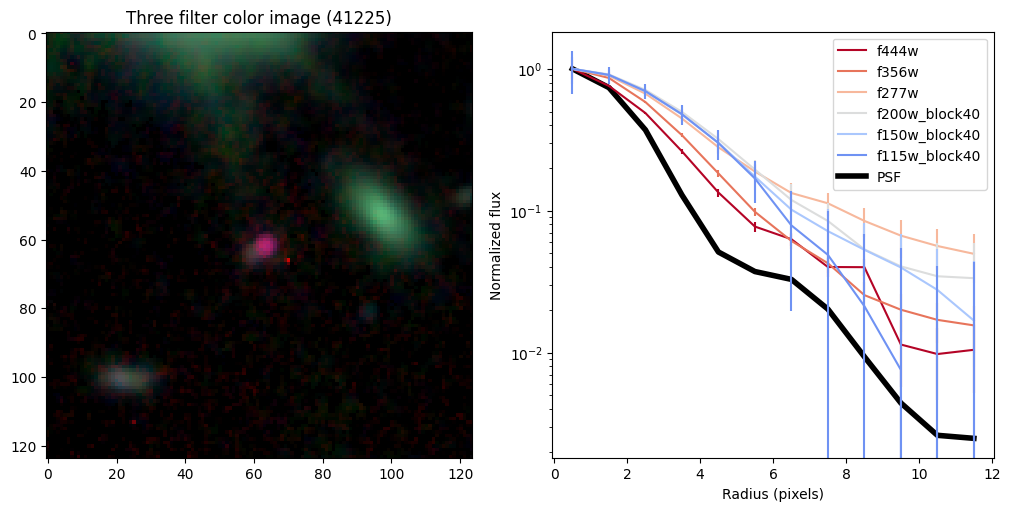

In [15]:
halfs = {}
for target in targets.keys():
    
    # load images
    images = np.load(f'data/{target}/sci.npy') # ['f277w','f356w','f444w']
    errors = np.load(f'data/{target}/err.npy')
    masks  = np.load(f'data/{target}/msk.npy')
    psfs   = np.load('data/psf.npy')

    
    # place we will put the plots
    fig = plt.figure(constrained_layout=True, figsize = (10,5))
    ax_dict = fig.subplot_mosaic(
        """
        AB
        """)
    
    # show color image
    rgb = visualization.make_lupton_rgb(images[2], images[-11], images[-14],
                                    stretch=0.2)
    
    ax_dict['A'].imshow(rgb)
    ax_dict['A'].set_title(f'Three filter color image ({target})')
    
    # radial profiles
    
    # start with PSF
    r_psf,f_psf,e_psf,a_psf = radial_profile(psf, np.ones_like(psf), step = step, steps = steps)
    f_psf /= a_psf

    _, _, _, half = find_half_light_radius( r_psf, f_psf/f_psf[0])

    half_light_radii = {}
    half_light_radii['psf'] = half

    # loop over bands
    count = 0 
    for i in range(len(bands)):
        if bands[i] in [ 'f444w',
                         'f356w',
                         'f277w',
                         'f200w_block40',
                         'f150w_block40',
                         'f115w_block40',
                       ]:
            
            sci = images[i]
            err = errors[i]

            r_sci,f_sci,e_sci,a_sci = radial_profile(sci, err, step = step, steps = steps)
            f_sci /= a_sci
            e_sci /= a_sci

            ax_dict['B'].plot(r_sci, f_sci/f_sci[0],
                             color =  plt.cm.coolwarm_r(count / 6.),
                             label=bands[i])
            ax_dict['B'].errorbar(r_sci, f_sci/f_sci[0], yerr = e_sci/f_sci[0],
                             color =  plt.cm.coolwarm_r(count / 6.), linestyle='')
            count += 1
            
            # log half light
            half_light_radii[bands[i]] = []
            for n in range(100):
                _, _, _, half = find_half_light_radius( r_sci, 
                                                    np.random.normal(f_sci/f_sci[0], e_sci/f_sci[0]) )
                half_light_radii[bands[i]].append( half )
                
            half_light_radii[bands[i]] = np.array(half_light_radii[bands[i]])
            
 
    ax_dict['B'].plot(r_psf, f_psf/f_psf[0],color='k',linewidth=4,zorder=-10,label='PSF')    
    ax_dict['B'].legend(loc='upper right')
    ax_dict['B'].set_ylabel('Normalized flux')
    ax_dict['B'].set_xlabel('Radius (pixels)')
    ax_dict['B'].set_yscale('log')

    halfs[target] = half_light_radii

# Compare the half-light radii of PSF, F115W, and F444W.

# - If $r_\mathrm{eff}(\mathrm{F444W}) / r_\mathrm{eff}(\mathrm{PSF})>1$ it is resolved.
# - If $r_\mathrm{eff}(\mathrm{F115W}) / r_\mathrm{eff}(\mathrm{F444W})>1$ blue light is more spatially extended than red light.
# - For fun, do these properties correlate with anything? Like redshift, magnification, etc?

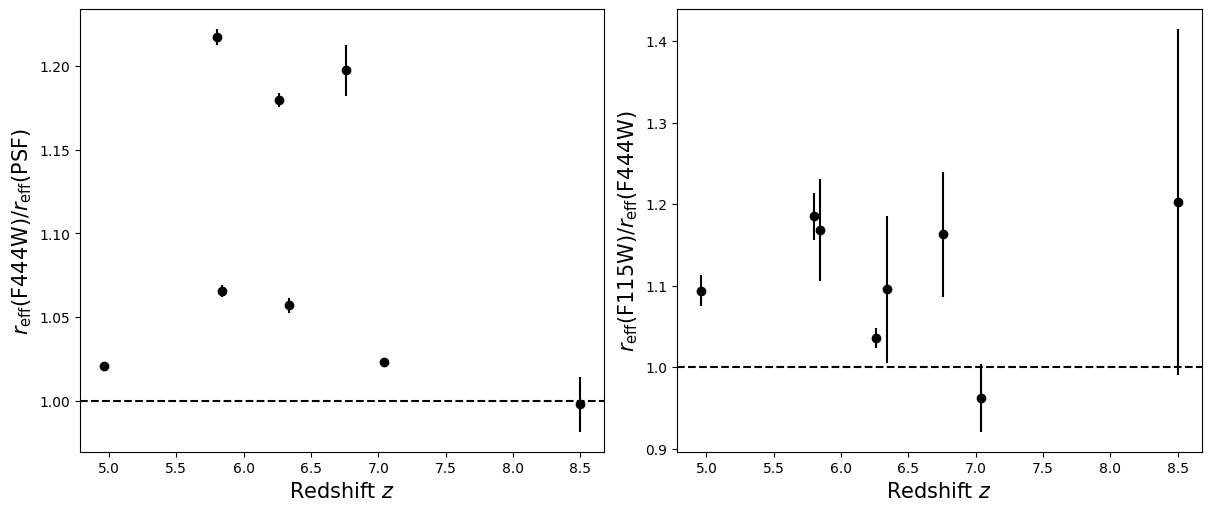

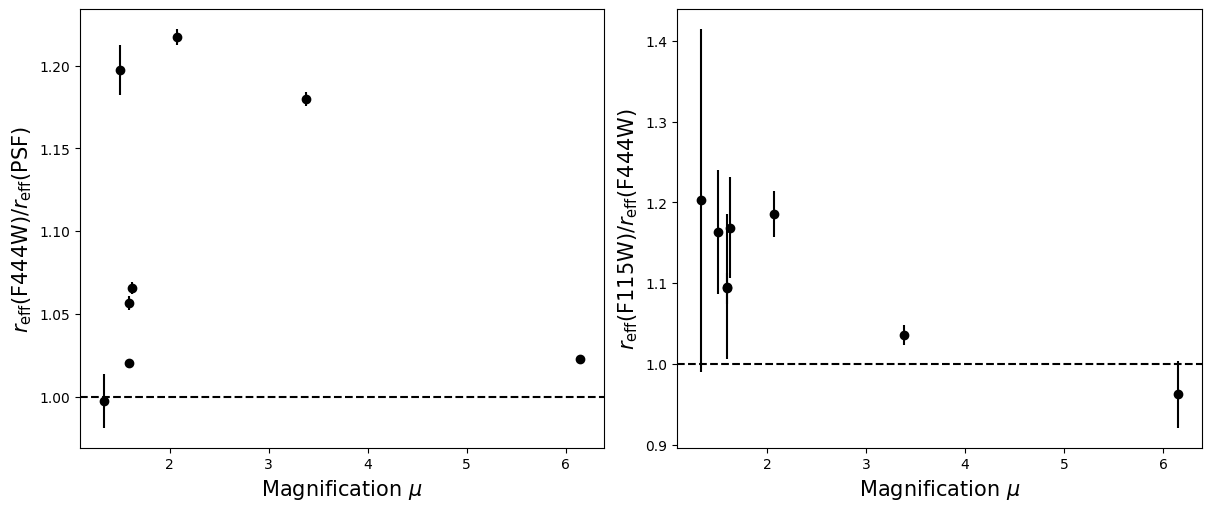

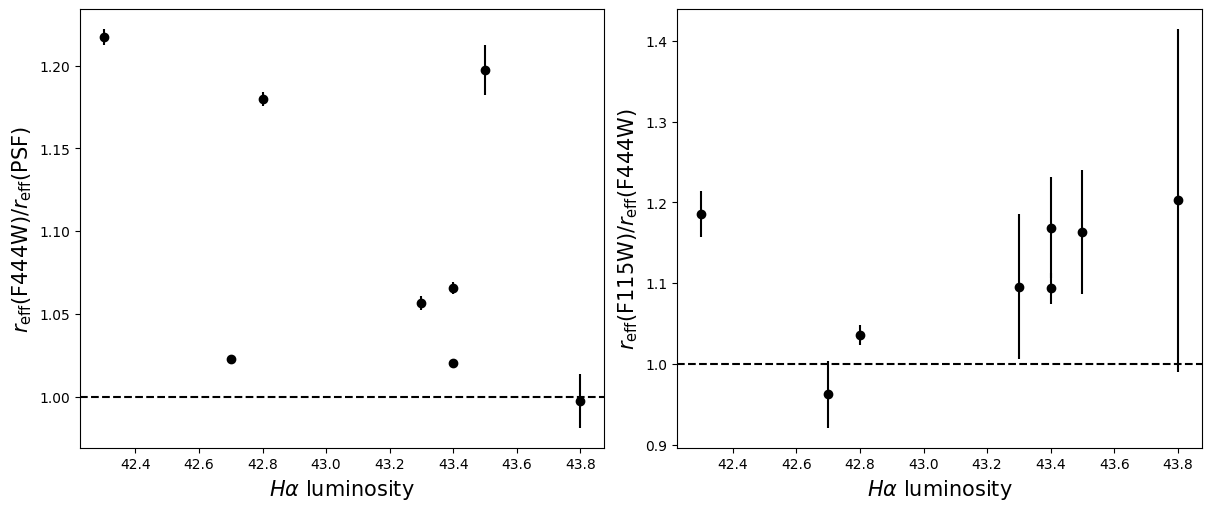

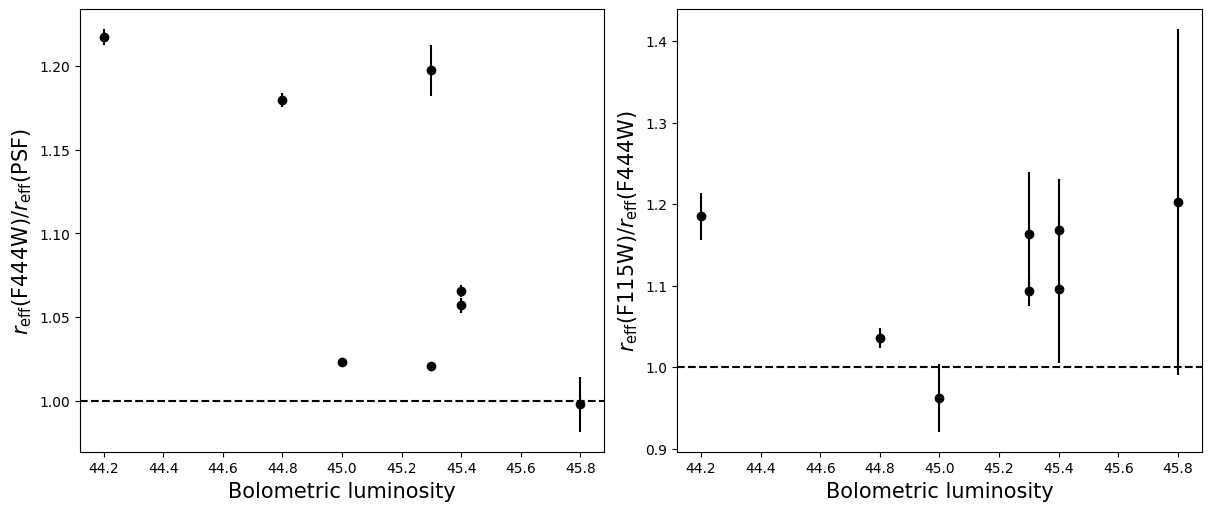

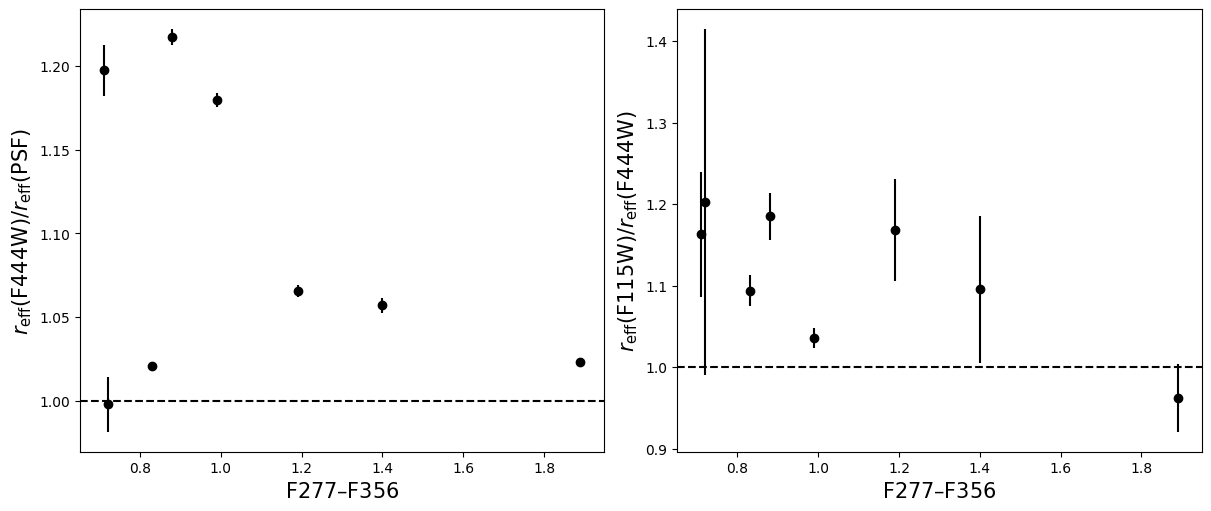

In [8]:
labels = ['Redshift $z$', 'Magnification $\mu$', 
          '$H\\alpha$ luminosity', 'Bolometric luminosity',
         'F277$–$F356']
for i in range(5):
    fig = plt.figure(constrained_layout=True, figsize = (12,5))
    ax_dict = fig.subplot_mosaic(
        """
        AB
        """)
    
    for target in targets:

        r =  halfs[target]['f444w'] / halfs[target]['psf']
        
        ax_dict['A'].errorbar(supplemental[target][i], np.median(r), yerr = np.std(r), linestyle='', 
                     marker = 'o', color='k')

        r =  halfs[target]['f115w_block40']  / halfs[target]['f444w']
        
        ax_dict['B'].errorbar(supplemental[target][i], np.median(r), yerr = np.std(r), linestyle='', 
                     marker = 'o', color='k')
        
    ax_dict['A'].axhline(1, linestyle='--',color='k')
    ax_dict['B'].axhline(1, linestyle='--',color='k')
    
    ax_dict['A'].set_xlabel(labels[i],fontsize=15)
    ax_dict['B'].set_xlabel(labels[i],fontsize=15)
    
    ax_dict['A'].set_ylabel('$r_\mathrm{eff}(\mathrm{F444W}) / r_\mathrm{eff}(\mathrm{PSF})$',fontsize=15)
    ax_dict['B'].set_ylabel('$r_\mathrm{eff}(\mathrm{F115W}) / r_\mathrm{eff}(\mathrm{F444W})$',fontsize=15)
    
